# Modele generatywne

W tym notebooku pobawimy się autoenkoderem, autoenkoderem wariacyjnym oraz GANem na zbiorze MNIST. Spróbujemy przygotować modele, które będą w stanie generować obrazy z zadanymi przez nas cechami (np. wybrane cyfry w określonym miejscu na obrazie).  
  
Do opracowania są 4 części: AE, VAE, conditioned VAE, conditioned GAN. Niektóre fragmenty wymagają samodzielnej implementacji.  
  
Notebook da się rozwiązać z wykorzystaniem colaba.  
  
Jako raport proszę przygotować plik pdf z odpowiedziami na zadania (są wyszczególnione w punktach), załączając przygotowane fragmenty kodu, opisy, wykresy - wszystko, co jest niezbędne do udokumentowania zrobienia zadania. Dodatkowo proszę załączyć notebook, w którym zawarta jest Państwa praca. Zwracam uwagę, że podstawą do oceny zadania jest <u>raport tekstowy</u> - w szczególności nie będę sprawdzać bezpośrednio notebooków (ale wymagam ich załączenia w celu potencjalnej weryfikacji tego, co jest opisane w raporcie). Oznacza to również, że notebook przekonwertowany do pdfa nie stanowi odpowiednio przygotowanego raportu.
  
Polecam tutorial dot. VAE: https://arxiv.org/pdf/1606.05908

Importy:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow_docs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 3.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import PIL
import imageio.v2 as imageio
import glob
import tensorflow_probability as tfp

In [5]:
import time
from IPython.display import display, clear_output
import tensorflow_docs.vis.embed as embed

Ładowanie danych:

In [6]:
(x_train_raw, y_train_raw), (x_test_raw, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 1. AutoEnkoder (AE)

Zajmiemy się prostym zbiorem danych MNIST, na którym pokażemy działanie wybranych modeli generatywnych.  
Zacznijmy od preprocessingu danych - normalizacji do przedziału [0; 1]:

In [7]:
def preprocess_images_ae(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return images.astype('float32')

x_train = preprocess_images_ae(x_train_raw)
x_test = preprocess_images_ae(x_test_raw)

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_raw, test_size=0.15, random_state=42)

In [9]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((51000, 28, 28, 1), (10000, 28, 28, 1), (51000,), (10000,))

In [10]:
train_size = x_train.shape[0]
test_size = x_test.shape[0]
val_size = x_val.shape[0]

batch_size = 32

Przygotujmy datasety:

In [12]:
train_dataset = (tf.data.Dataset.from_tensor_slices(x_train)
                 .shuffle(train_size).batch(batch_size))
val_dataset = (tf.data.Dataset.from_tensor_slices(x_val)
               .shuffle(val_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test)
                .shuffle(test_size).batch(batch_size))

W poniższej komórce znajduje się definicja autoenkodera przygotowanego pod kątem zbioru MNIST. Zapoznaj się z architekturą sieci, składającej się z enkodera oraz dekodera.

In [13]:
class Autoencoder(tf.keras.Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim),
        ]
    )
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same',
                activation='sigmoid'),
        ]
    )

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

Zadanie 1.1 - Dlaczego sigmoid jest odpowiednią funkcją aktywacji w ostatniej warstwie dekodera w tym przypadku? (0.25pkt)

Zadziałamy dość ekstremalnie, ustalając rozmiar przestrzeni ukrytej na 2. Zrobimy to w celu jej późniejszej wizualizacji (można by ustalić rozmiar na większy, a następnie zredukować wymiarowość przy pomocy innych metod, ale tym razem nie będziemy z tego korzystać):

In [ ]:
latent_dim = 2
autoencoder = Autoencoder(latent_dim)

Zadanie 1.2. Skompiluj model. W tym celu najpierw zdefiniuj loss dla modelu. W przypadku autoenkodera jest to funkcja działająca na wejściach do enkodera oraz wyjściach z dekodera. Do wyboru są różne funkcje! Patrząc na reprezentację danych (wróć do funkcji definiującej preprocessing), wybierz odpowiednią. Uzasadnij swój wybór. (0.25 pkt)

In [ ]:
autoencoder.compile(optimizer='adam', loss= 'binary_crossentropy')

Czas na trening:

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 81s 49ms/step - loss: 0.2751 - val_loss: 0.2039
Epoch 2/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 97s 59ms/step - loss: 0.2013 - val_loss: 0.1970
Epoch 3/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 133s 54ms/step - loss: 0.1955 - val_loss: 0.1936
Epoch 4/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 143s 55ms/step - loss: 0.1931 - val_loss: 0.1923
Epoch 5/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 148s 58ms/step - loss: 0.1913 - val_loss: 0.1907
Epoch 6/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 133s 52ms/step - loss: 0.1896 - val_loss: 0.1904
Epoch 7/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 106s 66ms/step - loss: 0.1891 - val_loss: 0.1897
Epoch 8/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 118s 51ms/step - loss: 0.1882 - val_loss: 0.1889
Epoch 9/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 81s 51ms/step - loss: 0.1874 - val_loss: 0.1884
Epoch 10/10
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 97s 60ms/step - loss: 0.1862 - val_loss: 0.1880


Wyświetlmy przykładowe obrazy oraz ich rekonstrukcje:

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

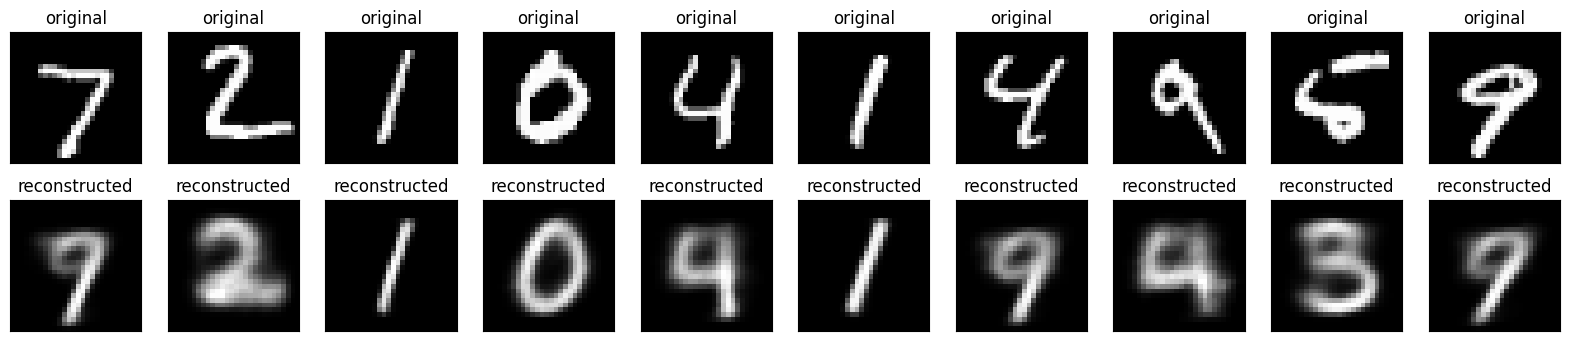

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

Jeśli nie jesteś zadowolona/y z jakości wyników, możesz pobawić się siecią/hiperparametrami użytymi podczas treningu. W tym przypadku umieść informację o zastosowanych zmianach w raporcie.

Zaimplementuj funkcję do wizualizacji reprezentacji obrazów ze zbioru testowego w ukrytej przestrzeni 2-wymiarowej. Wyświetl wizualizację.

In [ ]:
x_test

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [ ]:
def plot_latent_space(model, data):
  latent_representations = model.encoder(data).numpy()

  plt.figure(figsize = (10, 8))
  plt.scatter(latent_representations[:, 0], latent_representations[:, 1], c = 'b', alpha = 0.7, marker = 'x')
  plt.xlabel('Latent Dimension 1')
  plt.ylabel('Latent Dimension 2')
  plt.title('2D Latent Space Representation of MNIST Test Data (AE)')
  plt.show()

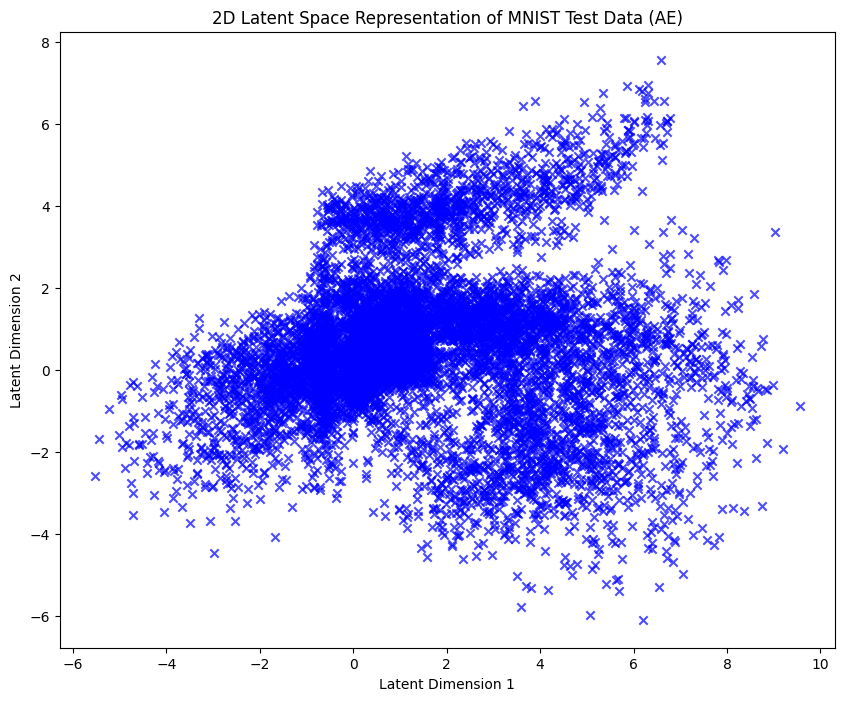

In [ ]:
plot_latent_space(autoencoder, x_test)

Teraz wyświetlmy obrazy powstałe przez dekodowanie wartości z prostokątnej siatki. Dobierz granice siatki, analizując wyniki funkcji plot_latent_space.

In [ ]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  grid_x = np.linspace(-6, 10, n)
  grid_y = np.linspace(-6.5, 8, n)
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.decoder(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

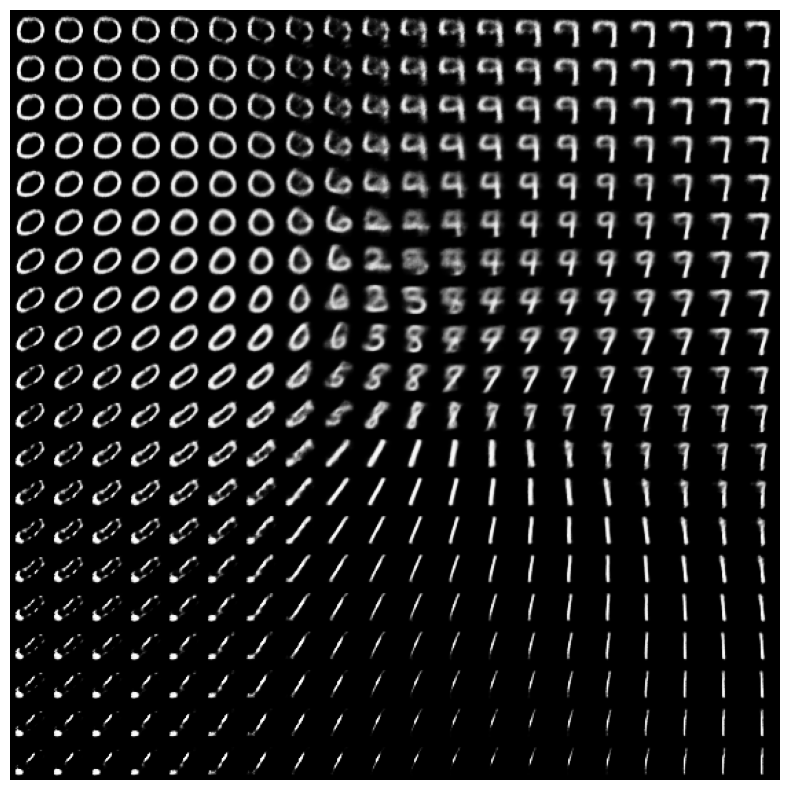

In [ ]:
plot_latent_images(autoencoder, 20)

Zadanie 1.3. Wybierz ze zbioru testowego dwa obrazy z różnymi liczbami. Dobierz takie liczby, dla których spodziewasz się, że odkodowanie średniej z ich zenkodowanych reprezentacji będzie miało sens. Wybierz dwie takie pary.  
Dla każdej z par:  
* Wyświetl wybrane liczby.  
* Użyj enkodera do uzyskania 2-wymiarowych reprezentacji każdej liczby.  
* Wylicz średnią z tych reprezentacji.  
* Użyj dekodera na uzyskanej średniej.  
* Wyświetl wynik.
* Skomentuj wynik - czy przypomina jakąś liczbę? Czy takiego wyniku się spodziewałaś/eś?  

(0.25pkt)


Łączna liczba punktów do uzyskania za tę część: 0.75

In [ ]:
def visualize_results_ae(first_number, second_number):
  fig, ax = plt.subplots(1, 3, figsize = (10, 6))
  ax[0].imshow(first_number, cmap = 'gray')
  ax[0].set_title('First number')
  ax[0].axis('off')
  ax[1].imshow(second_number, cmap = 'gray')
  ax[1].set_title('Second number')
  ax[1].axis('off')

  latent_2d_first_number = autoencoder.encoder(tf.expand_dims(first_number, axis = 0)).numpy()
  latent_2d_second_number = autoencoder.encoder(tf.expand_dims(second_number, axis = 0)).numpy()
  latent_2d_mean = (latent_2d_first_number + latent_2d_second_number) / 2
  decoded_mean = autoencoder.decoder(latent_2d_mean).numpy().squeeze()

  ax[2].imshow(decoded_mean, cmap = 'gray')
  ax[2].set_title('Decoded mean')
  ax[2].axis('off')
  plt.show()

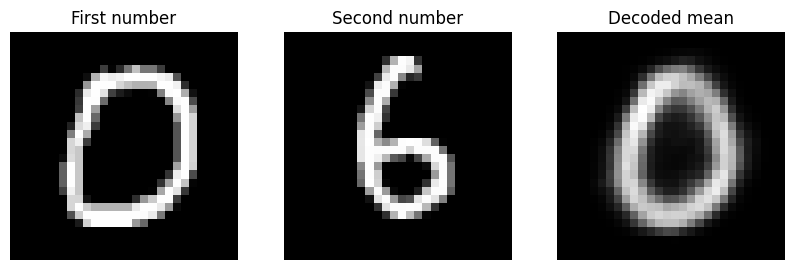

In [ ]:
number_zero = x_test[10]
number_six = x_test[21]

visualize_results_ae(number_zero, number_six)

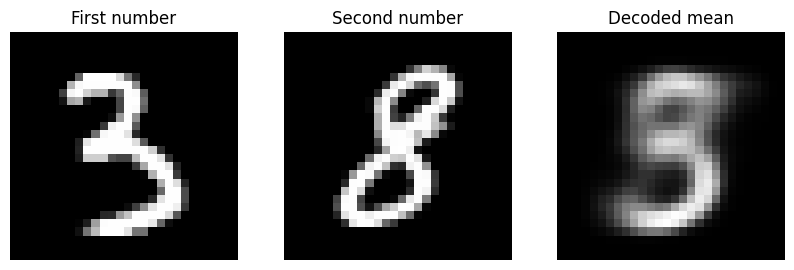

In [ ]:
number_three = x_test[32]
number_eight = x_test[110]

visualize_results_ae(number_three, number_eight)

# 2. AutoEnkoder wariacyjny (VAE)

Prosty AE nadaje się do różnych zadań, jak np. usuwanie szumu czy znajdowanie anomalii, ale nie jest najlepszą opcją do generowania obrazów z danego rozkładu (co widzieliśmy powyżej). W tej części zajmiemy się modelem znacznie lepiej nadającym się do tego zadania - autoenkoderem wariacyjnym.  
  
Zacznijmy od preprocessingu danych. Zwróć uwagę na reprezentację obrazów - tym razem będzie ona binarna - piksele będą mieć wartości 0/1. Będzie to miało wpływ na wybór funkcji kosztu! Moglibyśmy, oczywiście, dalej reprezentować obrazy jako wartości z całego zakresu [0; 1] i wtedy wykorzystać ten sam co wcześniej błąd rekonstrukcji, ale ponieważ takie podejście sprawdziliśmy wcześniej, tym razem zróbmy to inaczej.

In [14]:
def preprocess_images_vae(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

x_train = preprocess_images_vae(x_train_raw)
x_test = preprocess_images_vae(x_test_raw)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_raw, test_size=0.15, random_state=42)

In [16]:
train_size = x_train.shape[0]
test_size = x_test.shape[0]
val_size = x_val.shape[0]

batch_size = 32

In [17]:
train_dataset = (tf.data.Dataset.from_tensor_slices(x_train)
                 .shuffle(train_size).batch(batch_size))
val_dataset = (tf.data.Dataset.from_tensor_slices(x_val)
               .shuffle(val_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test)
                .shuffle(test_size).batch(batch_size))

Zdefiniujmy model.  
Na co szczególnie warto zwrócić uwagę?  
* Enkoder: ostatnia warstwa to warstwa gęsta, z liczbą neuronów równą 2 * rozmiar przestrzeni ukrytej. Te neurony będą kodować wartości średniej oraz wariancji rozkładu normalnego, z którego próbki chcemy podawać na wejście dekodera podczas generacji obrazów. W praktyce zamiast wariancji neurony kodują wartości _logvar_ - czyli logarytmu z wariancji. Dzięki temu, że logarytm może przyjmować dowolne rzeczywiste wartości, unikamy konieczności optymalizacji wartości niezerowych.  
* Dekoder: zwróć uwagę na brak aktywacji w ostatniej warstwie dekodera, pomimo, że przecież generujemy obrazy z wartościami pikseli $\in$ {0, 1}. Jest to związane z preferowanym sposobem wyliczania funkcji kosztu, którą w tym wypadku jest cross-entropia. Zwróć uwagę na wywołanie funkcji _sigmoid_cross_entropy_with_logits_ z poziomu _compute_loss_. Moglibyśmy równie dobrze użyć aktywacji sigmoid, a następnie wyliczyć cross-entropię, ale podejście wykorzystujące _sigmoid_cross_entropy_with_logits_ jest bardziej stabilne numerycznie.

In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

Zadanie 2.1. Dlaczego powyższa implementacje CVAE nie stosuje żadnej aktywacji w ostatniej warstwie enkodera? Czy jakaś funkcja by się tutaj nadawała? (0.25pkt)

Zdefiniujmy dodatkowe funkcje: wyliczanie kosztu, wykonanie kroku treningu.  
Zwróć uwagę na funkcję kosztu. Składa się ona z trzech członów:  
$log P(X|z)$ - człon związany z odkodowanymi obrazami. Można go interpretować jako błąd rekonstrukcji.  
$logP(z)$ - człon związany z rozkładem, z którego losujemy elementy na wejście dekodera (prior).  
$logQ(z|X)$ - człon związany z aproksymowanym rozkładem $P(z|X)$ z pomocą prostszego rozkładu $Q(z|X)$ (posterior).

In [18]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Zdefiniujmy parametry treningu.

In [ ]:
epochs = 10
latent_dim = 2
optimizer = tf.keras.optimizers.Adam(1e-4)

Po każdej epoce będziemy wizualizować generację obrazów powstałych przez podanie na wejściu dekodera reprezentacji powstałej z tych samych obrazów ze zbioru testowego. W ten sposób będziemy mogli obserwować poprawę jakości generacji w każdej epoce.

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
num_examples_to_generate = 16

# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Zainicjalizujmy model i przeprowadźmy trening:

In [ ]:
model = CVAE(latent_dim)

Epoch: 10, Val set ELBO: -158.04183959960938, time elapse for current epoch: 78.71325755119324


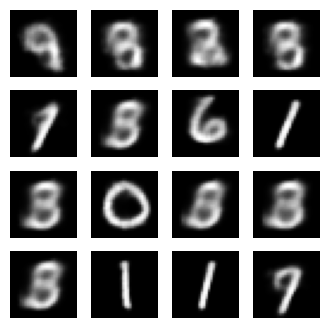

In [ ]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for val_x in val_dataset:
    loss(compute_loss(model, val_x))
  elbo = -loss.result()
  clear_output()
  print('Epoch: {}, Val set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

Z zapisanych podczas treningu obrazów możemy przygotować i wyświetlić gif:

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


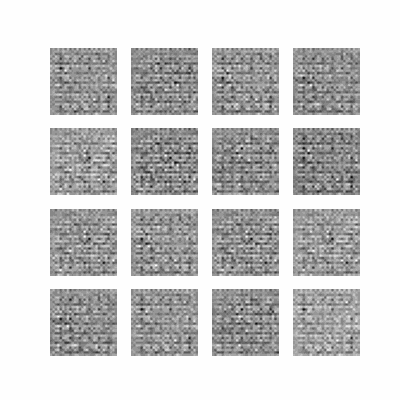

In [ ]:
embed.embed_file(anim_file)

Narysujmy teraz, podobnie jak wcześniej dla AE, dwuwymiarową przestrzeń ukrytą. Zaimplementuj funkcję plot_latent_space, która zenkoduje zbiór danych, a następnie wyświetli każdy punkt wraz z odchyleniem standardowym.

In [ ]:
def plot_latent_space(model, data):
  mean, logvar = model.encode(data)
  stddev = tf.exp(0.5 * logvar)
  mean = mean.numpy()
  stddev = stddev.numpy()

  plt.figure(figsize = (10, 8))
  plt.scatter(mean[:, 0], mean[:, 1], c = 'b', alpha = 0.7, marker = 'x')

  for i in range(len(mean)):
    plt.plot([mean[i, 0], mean[i, 0] + stddev[i, 0]], [mean[i, 1], mean[i, 1]], 'g-', alpha = 0.7)
    plt.plot([mean[i, 0], mean[i, 0] - stddev[i, 0]], [mean[i, 1], mean[i, 1]], 'g-', alpha = 0.7)
    plt.plot([mean[i, 0], mean[i, 0]], [mean[i, 1], mean[i, 1] + stddev[i, 1]], 'r-', alpha = 0.7)
    plt.plot([mean[i, 0], mean[i, 0]], [mean[i, 1], mean[i, 1] - stddev[i, 1]], 'r-', alpha = 0.7)

  plt.xlabel('Latent Dimension 1')
  plt.ylabel('Latent Dimension 2')
  plt.title('2D Latent Space Representation with Standard Deviations of MNIST Test Data (VAE)')
  plt.show()

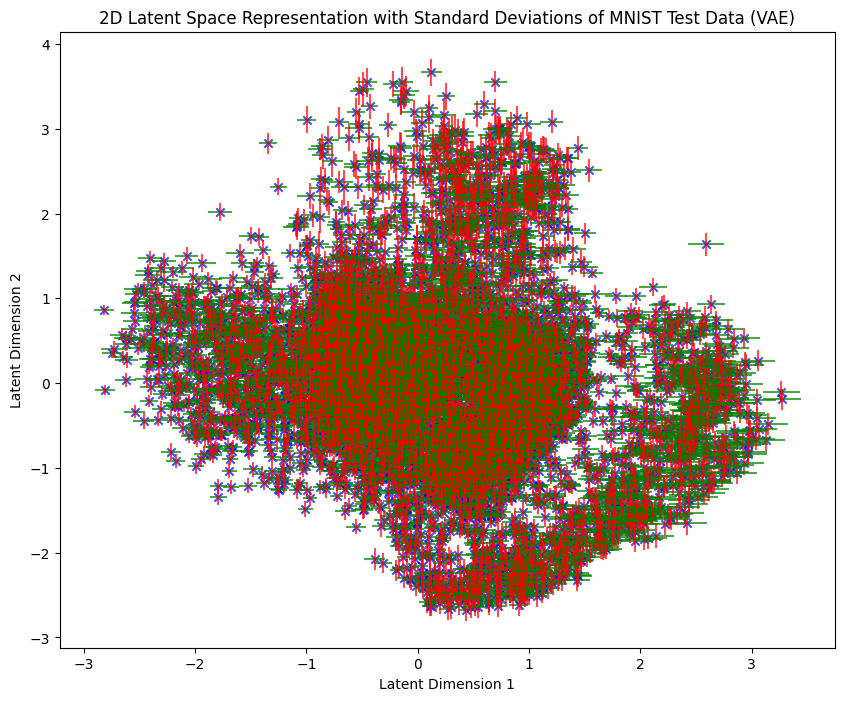

In [ ]:
plot_latent_space(model, x_test)

Narysujmy również odkodowane obrazy, podając na wejście dekodera wartości z rozkładu normalnego:

In [ ]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

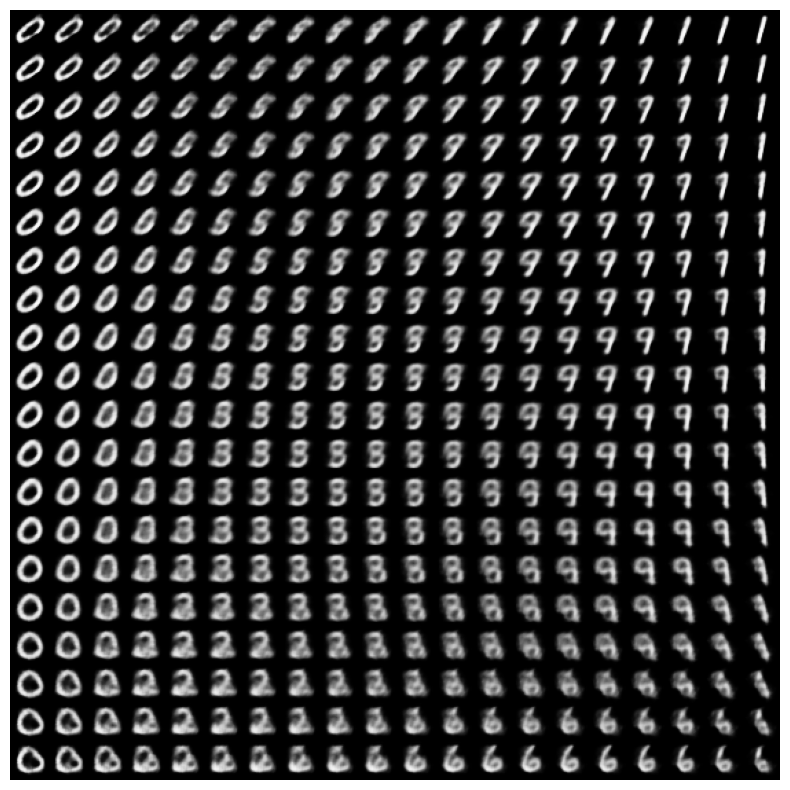

In [ ]:
plot_latent_images(model, 20)

Zadanie 2.2. Skomentuj wynik uzyskany przy użyciu funkcji plot_latent_images. Zwróć uwagę na jakość/sensowność rysowanych liczb. Porównaj wykres do analogicznego wykresu dla modelu AE. Zamieść w raporcie wykresy. (0.25pkt)  
  
Zadanie 2.3. Porównaj wyniki funkcji _plot_latent_space_ dla AE oraz VAE. Zwróć uwagę na "gęstość" punktów oraz zakres wartości. Zamieść w raporcie wykresy. (0.25pkt)   
  
Zadanie 2.4. Dla tych samych par obrazów, na których pracowałaś/eś w ostatnim zadaniu dot. AE, przygotuj reprezentacje ukryte z pomocą wytrenowanego VAE i odkoduj średnie z reprezentacji. Skomentuj wyniki, porównaj z wynikami z AE. (0.25pkt)  
  
Zadanie 2.5. Wróć do funkcji _compute_loss_. Człony _logpz_ oraz _logqz\_x_ związane są z obliczaniem KL-divergence pomiędzy $Q(z|X)$ oraz $P(z)$. Zakładamy, że oba te rozkłady są gaussowskie, stąd możemy wykorzystać wzór na KL-divergence dla dwóch rozkładów gaussowskich. Znajdź ten wzór oraz przepisz funkcję _compute_loss_ z jego wykorzystaniem. Zamieść w raporcie przygotowaną formułę. Wytrenuj model ponownie, porównaj wyniki z poprzednią implementacją _compute_loss_. (0.25pkt)


UWAGA: jeśli na którymkolwiek etapie nie jesteś zadowolona/y z działania modelu, możesz dokonać jego modyfikacji (podobnie jak dla AE).

Łączna liczba punktów do uzyskania za tę część: 1.25

In [ ]:
def visualize_results_vae(first_number, second_number):
  fig, ax = plt.subplots(1, 3, figsize = (10, 6))
  ax[0].imshow(first_number, cmap = 'gray')
  ax[0].set_title('First number')
  ax[0].axis('off')
  ax[1].imshow(second_number, cmap = 'gray')
  ax[1].set_title('Second number')
  ax[1].axis('off')

  mean_first_number, logvar_first_number = model.encode(tf.expand_dims(first_number, axis = 0))
  mean_second_number, logvar_second_number = model.encode(tf.expand_dims(second_number, axis = 0))
  mean_of_mean = (mean_first_number.numpy() + mean_second_number.numpy()) / 2
  mean_of_logvar = (logvar_first_number.numpy() + logvar_second_number.numpy()) / 2
  z = model.reparameterize(mean_of_mean, mean_of_logvar)
  decoded_mean = model.decode(z).numpy().squeeze()

  ax[2].imshow(decoded_mean, cmap = 'gray')
  ax[2].set_title('Decoded mean')
  ax[2].axis('off')
  plt.show()

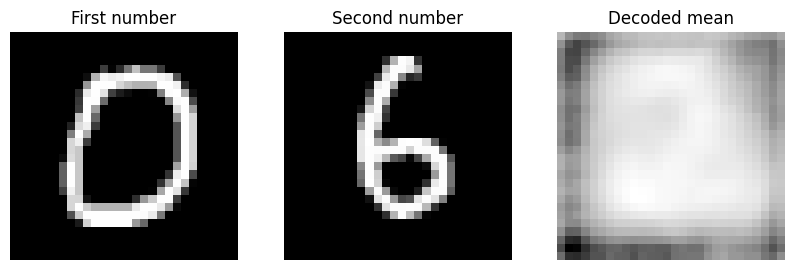

In [ ]:
visualize_results_vae(number_zero, number_six)

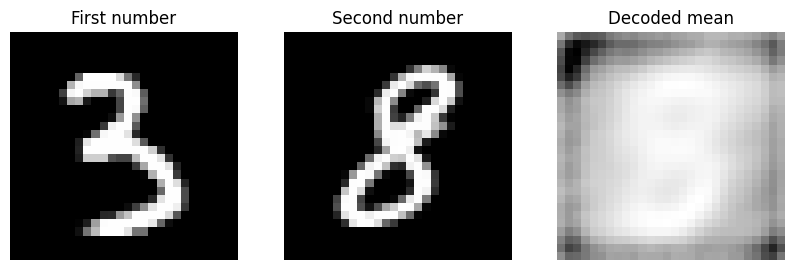

In [ ]:
visualize_results_vae(number_three, number_eight)

Zadanie 2.5. Wróć do funkcji compute_loss. Człony logpz oraz logqz_x związane są z obliczaniem KL-divergence pomiędzy  Q(z|X)  oraz  P(z) . Zakładamy, że oba te rozkłady są gaussowskie, stąd możemy wykorzystać wzór na KL-divergence dla dwóch rozkładów gaussowskich. Znajdź ten wzór oraz przepisz funkcję compute_loss z jego wykorzystaniem. Zamieść w raporcie przygotowaną formułę. Wytrenuj model ponownie, porównaj wyniki z poprzednią implementacją compute_loss. (0.25pkt)

In [19]:
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  kl_div = 0.5 * tf.reduce_sum(logvar + tf.square(mean) + tf.exp(logvar) - 1, axis=1)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x + kl_div)

Epoch: 10, Val set ELBO: -160.7881622314453, time elapse for current epoch: 78.24462747573853


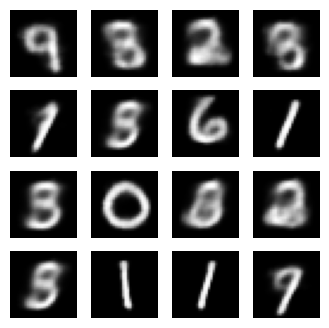

In [ ]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for val_x in val_dataset:
    loss(compute_loss(model, val_x))
  elbo = -loss.result()
  clear_output()
  print('Epoch: {}, Val set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [ ]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


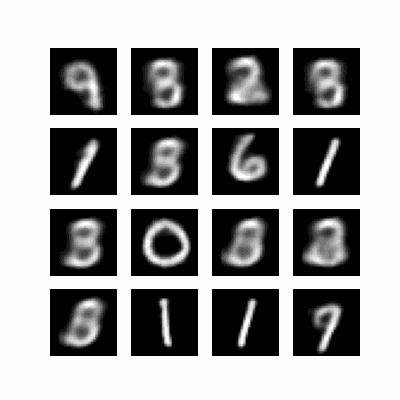

In [ ]:
embed.embed_file(anim_file)

# 3. Conditioned VAE

W tej części rozszerzymy model VAE poprzez dodanie do modelu informacji o generowanym obrazie. Przygotujemy nowy zbiór danych, bazujący na MNIST, który będzie zawierał cyfry w różnych miejscach. Będziemy rozważać 9 pozycji, rozmieszczonych na siatce 3x3. Dodatkową informacją będzie 12-elementowy wektor, zawierający: etykietę (one-hot), położenie x, położenie y cyfry.  

Zacznijmy od przygotowania zbioru danych. Będziemy generować obrazy w rozmiarze (42, 42), a bazowe cyfry będą mieć rozmiar (14, 14).

In [20]:
x_train_small = tf.image.resize(x_train, (14, 14)).numpy()
x_val_small = tf.image.resize(x_val, (14, 14)).numpy()
x_test_small = tf.image.resize(x_test, (14, 14)).numpy()

In [21]:
encoder = OneHotEncoder()

In [22]:
y_train = encoder.fit_transform(y_train.reshape((-1, 1))).toarray()
y_val = encoder.transform(y_val.reshape((-1, 1))).toarray()
y_test = encoder.transform(y_test.reshape((-1, 1))).toarray()

In [23]:
x_train_small.shape, y_train.shape

((51000, 14, 14, 1), (51000, 10))

Uzupełnij funkcję, która z każdego obrazu ze zbioru danych x tworzy 9 obrazów z cyfrą na każdej z 9 pozycji siatki 3x3, a także tworzy etykiety y w postaci wektora [cyfra-one-hot, pozycja_x, pozycja_y]. Dla każdej pary z oryginalnego zbioru danych (obraz, etykieta) wylosuj num_imgs par, które znajdą się w docelowym zbiorze danych (nie zapisujemy wszystkich 9 możliwości ze względu na ograniczenia RAM).

In [24]:
def conditioned_mnist(x, y, num_imgs=2):
  x_res = np.empty(shape=(x.shape[0] * num_imgs, 3 * x.shape[1], 3 * x.shape[2]), dtype='float32')  # pusta macierz z wynikami - obrazy x
  y_res = np.empty(shape=(y.shape[0] * num_imgs, 2 + y.shape[1]), dtype='float32')  # pusta macierz z wynikami - wektor y: etykieta (10 liczb), pozycja x, pozycja y
  empty_res = np.zeros(shape=(3 * x.shape[1], 3 * x.shape[2]))  # obraz wynikowy w docelowym rozmiarze, wypełniony zerami

  for el, (arr, label) in enumerate(zip(x, y)):
    to_sample_x = np.empty((9, x.shape[1]*3, x.shape[2]*3), dtype='float32')  # macierz przechowująca 9 wersji obrazu
    to_sample_y = np.empty((9, 12), dtype='float32')  # macierz przechowująca 9 wersji etykiet
    for i in range(3):
      for j in range(3):
        curr_x = empty_res.copy()
        curr_x[i*x.shape[1]: (i+1)*x.shape[1], j*x.shape[2]: (j+1)*x.shape[2]] = arr.reshape((x.shape[1], x.shape[2]))
        curr_y = [*label, i/2, j/2]  # normalizacja
        to_sample_x[3*i+j] = curr_x
        to_sample_y[3*i+j] = curr_y
    idxs = np.random.choice(9, num_imgs, replace = False)  # wylosuj num_imgs indeksów z zakresu [0; 8] jako wektor numpy
    x_res[el*num_imgs: (el+1)*num_imgs] = to_sample_x[idxs]
    y_res[el*num_imgs: (el+1)*num_imgs] = to_sample_y[idxs]
  x_res = x_res.reshape((-1, x.shape[1]*3, x.shape[2]*3, 1))
  return x_res, y_res


Przygotujmy zbiór danych, zawierający po 2 wersje dla każdego obrazu:

In [25]:
num_imgs = 2

In [26]:
x_train_cond, y_train_cond = conditioned_mnist(x_train_small, y_train, num_imgs)

In [27]:
x_train_cond.shape, y_train_cond.shape

((102000, 42, 42, 1), (102000, 12))

In [28]:
x_val_cond, y_val_cond = conditioned_mnist(x_val_small, y_val)
x_test_cond, y_test_cond = conditioned_mnist(x_test_small, y_test)

Uzupełnij klasę Cond_CVAE na podstawie klasy CVAE. W tym celu:  
1. Uzupełnij funkcję prepare_encoder. Będziemy mieć dwa wejścia do modelu - jedno na obraz, jedno na wektor cech [etykieta, pos_x, pos_y]. Przeprocesuj obraz z pomocą warstw konwolucyjnych (możesz wykorzystać implementację z CVAE). Możesz też przygotować kilka warstw, które zajmą się wektorem cech. Użyj warstwy konkatenującej wyniki z przetwarzania obrazu i wektora cech. Za tą warstwą znajdzie się warstwa gęsta, wyliczająca średnią i logvar.  
  
2. Uzupełnij funkcję prepare_decoder. Tu również mamy do czynienia z dwoma wejściami - jedno przyjmuje szum, drugie wektor cech. Połącz oba wejścia i przygotuj dekoder. Możesz skorzystać z implementacji CVAE, ale będą potrzebne zmiany związane z innym rozmiarem obrazów.

Pozostałe funkcje są już zaimplementowane. Przyjrzyj się im. Co się zmieniło względem implementacji CVAE?


In [29]:
class Cond_CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(Cond_CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = self.prepare_encoder()
    self.decoder = self.prepare_decoder()

  def prepare_encoder(self):
    input_img = tf.keras.layers.Input(shape=(42, 42, 1))
    input_cond = tf.keras.layers.Input(shape=(12, ))

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding='same')(x)
    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Concatenate()([x, input_cond])
    # No activation
    x = tf.keras.layers.Dense(latent_dim + latent_dim)(x)
    return  tf.keras.Model([input_img, input_cond], [x])

  def prepare_decoder(self):
    input_latent = tf.keras.layers.Input(shape=(latent_dim,))
    input_cond = tf.keras.layers.Input(shape=(12, ))
    inputs = tf.keras.layers.Concatenate()([input_latent, input_cond])

    x = tf.keras.layers.Dense(7 * 7 * 32, activation=tf.nn.relu)(inputs)
    x = tf.keras.layers.Reshape(target_shape=(7, 7, 32))(x)

    x = tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=1, padding='same')(x)
    return tf.keras.Model([input_latent, input_cond], [x])


  @tf.function
  def sample(self, cond, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode([eps, cond], apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, inputs, apply_sigmoid=False):
    logits = self.decoder(inputs)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

Przygotowanie do treningu:

In [30]:
epochs = 10
batch_size = 32

In [31]:
num_examples_to_generate = 16

Nie będziemy tym razem wizualizować przestrzeni ukrytej, ale zacznijmy od latent_dim=2.

In [32]:
latent_dim = 2
model = Cond_CVAE(latent_dim)

In [33]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train_cond).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices(x_val_cond).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test_cond).batch(batch_size)

train_dataset_cond = tf.data.Dataset.from_tensor_slices(y_train_cond).batch(batch_size)
val_dataset_cond = tf.data.Dataset.from_tensor_slices(y_val_cond).batch(batch_size)
test_dataset_cond = tf.data.Dataset.from_tensor_slices(y_test_cond).batch(batch_size)

train_dataset_with_cond = tf.data.Dataset.zip((train_dataset, train_dataset_cond)).shuffle(train_size*num_imgs)
val_dataset_with_cond = tf.data.Dataset.zip((val_dataset, val_dataset_cond)).shuffle(val_size*num_imgs)
test_dataset_with_cond = tf.data.Dataset.zip((test_dataset, test_dataset_cond)).shuffle(test_size*num_imgs)

In [34]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset_with_cond.take(1):
  test_sample_data = test_batch[0][0:num_examples_to_generate, :, :, :]
  test_sample_cond = test_batch[1][0:num_examples_to_generate, :]
test_sample = [test_sample_data, test_sample_cond]

Uzupełnij funkcję kosztu:

In [40]:
def compute_loss(model, x):
  data, cond = x
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode([z, cond])
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=data)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

Ostatnie definicje/inicjalizacje:

In [41]:
def generate_and_save_images(model, epoch, test_sample):
  data, cond = test_sample
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(cond, z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [42]:
@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [43]:
optimizer = tf.keras.optimizers.Adam(1e-4)

...i zaczynamy trening.

Epoch: 10, Val set ELBO: -40.50996017456055, time elapse for current epoch: 15.58200716972351


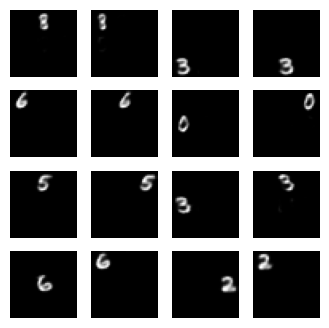

In [ ]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset_with_cond:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for val_x in val_dataset_with_cond:
    loss(compute_loss(model, val_x))
  elbo = -loss.result()
  clear_output()
  print('Epoch: {}, Val set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [ ]:
anim_file = 'cond_cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


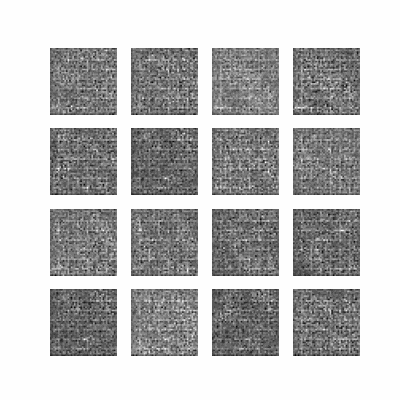

In [ ]:
embed.embed_file(anim_file)

Jeśli model zupełnie nie radzi sobie z zadaniem, pobaw się definicją modelu bądź hiperparametrami (głównie batch_size, liczba epok). Model powinien zwracać rozsądne wyniki zarówno w konktekście położenia, jak i rodzaju generowanej cyfry.

Zadanie 3.1. Sprawdź jakość modelu dla 3 różnych wartości latent_dim (trzeba dla każdej z nich osobno wytrenować model). Niech będą od siebie znacząco różne, np. 2, 25, 100. Przy większym latent_dim może być potrzebnych więcej epok.  
Punktacja:  
Skuteczny trening dla jednej wartości latent dim = 1 pkt.  
0.5 pkt za testy dla dwóch innych wartości latent_dim (po 0.25 za każdą). Punkty będą przyznane, jeśli model będzie w stanie generować _sensowne_ wyniki.  
  
Zadanie 3.2. Wykonaj dla najlepszego modelu z punktu 3.1.:
* Wybierz przykład ze zbioru testowego (obraz + etykieta).  
* Przepuść próbkę przez enkoder, uzyskaj reprezentację _z_.  
* Dla każdego z 9 możliwych wektorów [poprawna_etykieta, pos_x, pos_y] przepuść przez dekoder reprezentację _z_ wraz z informacją o etykiecie i położeniu. Wyświetl uzyskany obraz. Skomentuj wyniki - czy za każdym razem uzyskano oczekiwaną liczbę w oczekiwanym miejscu? Jeśli nie, to co może być przyczyną? (0.25 pkt)  

Zadanie 3.3. Powtórz zadanie 3.2, ale tym razem jako reprezentację _z_ wykorzystaj wartości wylosowane z rozkładu normalnego oraz wybierz dowolną etykietę. Skomentuj wyniki - czy za każdym razem uzyskano oczekiwaną liczbę w oczekiwanym miejscu? (0.25 pkt)


Za tę część: 2 punkty

Zadanie 3.1

In [ ]:
latent_dim = 20
epochs = 50
model = Cond_CVAE(latent_dim)

Epoch: 50, Val set ELBO: -37.065189361572266, time elapse for current epoch: 17.363019704818726


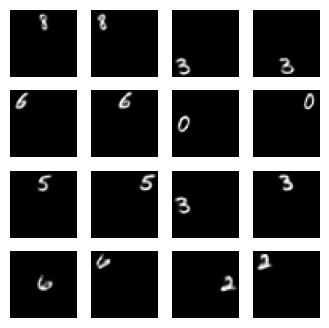

In [ ]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset_with_cond:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for val_x in val_dataset_with_cond:
    loss(compute_loss(model, val_x))
  elbo = -loss.result()
  clear_output()
  print('Epoch: {}, Val set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)


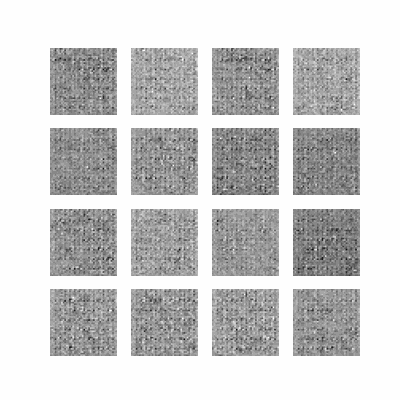

In [ ]:
embed.embed_file(anim_file)

In [44]:
latent_dim = 100
epochs = 150
model = Cond_CVAE(latent_dim)

Epoch: 150, Val set ELBO: -36.51435089111328, time elapse for current epoch: 17.80129098892212


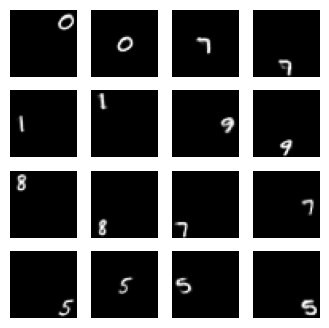

In [45]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset_with_cond:
    train_step(model, train_x, optimizer) # zdecydowałem się na 150 epokę i przerwałem uczenie by nie wyczerpać limitu
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for val_x in val_dataset_with_cond:
    loss(compute_loss(model, val_x))
  elbo = -loss.result()
  clear_output()
  print('Epoch: {}, Val set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

Zadanie 3.2

In [92]:
assert batch_size >= 1
for test_batch in test_dataset_with_cond.take(1):
  test_sample_data = test_batch[0][0:1, :, :, :]
  test_sample_cond = test_batch[1][0:1, :]
test_sample = [test_sample_data, test_sample_cond]

In [93]:
data, cond = test_sample
mean, logvar = model.encode(test_sample)
z = model.reparameterize(mean, logvar)

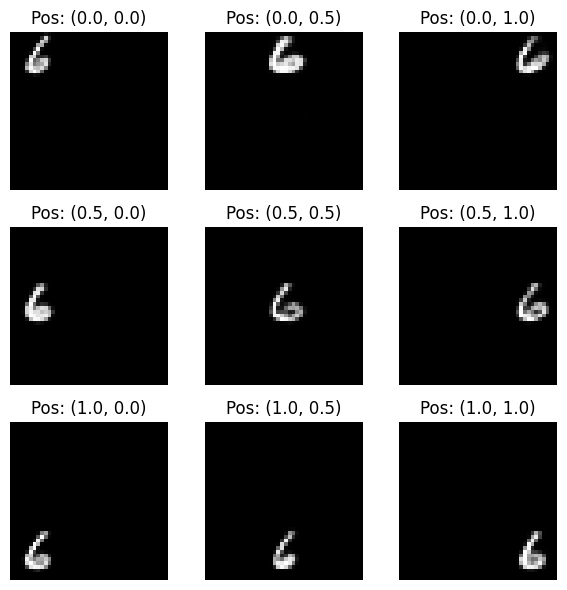

In [94]:
vectors = []

for x_pos in [0, 0.5, 1]:
    for y_pos in [0, 0.5, 1]:
        label = cond[0, :10]
        new_cond = tf.concat([label, [x_pos, y_pos]], axis=0)
        vectors.append(new_cond.numpy())

generated_images = []

for vector in vectors:
    cond_tensor = tf.convert_to_tensor(vector.reshape(1, -1), dtype=tf.float32)
    generated_image = model.sample(cond_tensor, z)
    generated_images.append(generated_image.numpy().squeeze())

fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Pos: ({vectors[i][10]}, {vectors[i][11]})')

plt.tight_layout()
plt.show()

Zadanie 3.3

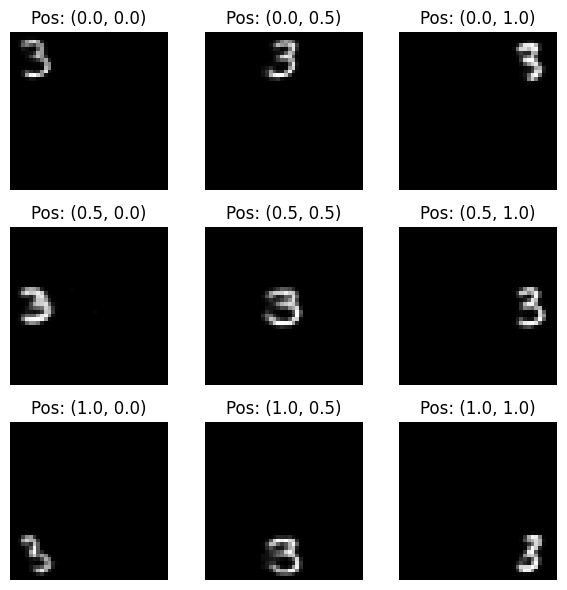

In [96]:
data, cond = next(iter(test_dataset_with_cond))
chosen_label = cond[0, :10]
vectors = []

for x_pos in [0, 0.5, 1]:
    for y_pos in [0, 0.5, 1]:
        new_cond = tf.concat([chosen_label, [x_pos, y_pos]], axis = 0)
        vectors.append(new_cond.numpy())

generated_images = []

for vector in vectors:
    z = tf.random.normal(shape=(1, model.latent_dim))
    cond_tensor = tf.convert_to_tensor(vector.reshape(1, -1), dtype = tf.float32)
    generated_image = model.sample(cond_tensor, z)
    generated_images.append(generated_image.numpy().squeeze())

fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i], cmap = 'gray')
    ax.axis('off')
    ax.set_title(f'Pos: ({vectors[i][10]}, {vectors[i][11]})')

plt.tight_layout()
plt.show()

# 4. Conditioned GAN

W ostatniej części wytrenujemy sieć GAN na obrazach ze zbioru MNIST. Ponownie przygotujemy implementację z dodatkowym wektorem wejściowym - tym razem będzie to wektor jednoelementowy z etykietą.

Wracamy do ciągłej reprezentacji obrazów:

In [ ]:
def preprocess_images_gan(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return images.astype('float32')

x_train = preprocess_images_gan(x_train_raw)
y_train = encoder.transform(y_train_raw.reshape((-1, 1))).toarray()

In [ ]:
y_train.shape

(60000, 10)

In [ ]:
train_size = x_train.shape[0]

batch_size = 256

Przygotujmy dataset. Będzie on zawierał:
* Obrazy.
* Dodatkowe wektory wejściowe z etykietami.
* Wektory wejściowe z etykietami do generowania przykładów przez generator w trakcie treningu.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)
train_dataset_cond = tf.data.Dataset.from_tensor_slices(y_train).batch(batch_size)
train_dataset_fake_cond = tf.data.Dataset.from_tensor_slices(y_train).shuffle(train_size).batch(batch_size)

train_dataset_with_cond = tf.data.Dataset.zip((train_dataset, train_dataset_cond, train_dataset_fake_cond)).shuffle(train_size)

Uzupełnij definicję generatora:

In [ ]:
def prepare_generator(latent_dim, cond_dim):
  input_img = tf.keras.layers.Input(shape=(latent_dim,))
  input_cond = tf.keras.layers.Input(shape=(cond_dim,))
  inputs = tf.keras.layers.Concatenate(axis=1)([input_img, input_cond])

  x1 = tf.keras.layers.Dense(7*7*256, use_bias=False)(inputs)
  x1 = tf.keras.layers.BatchNormalization()(x1)
  x1 = tf.keras.layers.LeakyReLU()(x1)
  x1 = tf.keras.layers.Reshape((7, 7, 256))(x1)

  x1 = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x1)
  x1 = tf.keras.layers.BatchNormalization()(x1)
  x1 = tf.keras.layers.LeakyReLU()(x1)

  x1 = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x1)
  x1 = tf.keras.layers.BatchNormalization()(x1)
  x1 = tf.keras.layers.LeakyReLU()(x1)

  x1 = tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x1)

  return tf.keras.Model([input_img, input_cond], x1, name='generator')

In [ ]:
latent_dim = 100
cond_dim = 10

Wyświetlmy obraz wygenerowany przez niewytrenowany generator przy podaniu na wejściu etykiety "1":

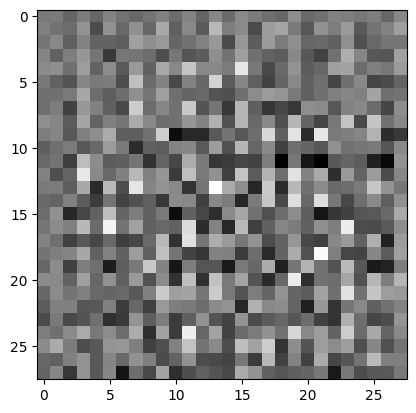

In [ ]:
generator = prepare_generator(latent_dim, cond_dim)

noise = tf.random.normal([1, latent_dim])
label = tf.constant(np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(1, -1))
generated_image = generator([noise, label], training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Uzupełnij definicję dyskryminatora:

In [ ]:
def prepare_discriminator(img_shape, cond_dim):
  input_img = tf.keras.layers.Input(shape=img_shape)
  x = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(input_img)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.Dropout(0.3)(x)

  x = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.Dropout(0.3)(x)

  x = tf.keras.layers.Flatten()(x)

  input_cond = tf.keras.layers.Input(shape=(cond_dim,))
  x = tf.keras.layers.Concatenate(axis=1)([x, input_cond])

  x = tf.keras.layers.Dense(256)(x)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.Dropout(0.3)(x)

  x = tf.keras.layers.Dense(128)(x)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = tf.keras.layers.Dense(1)(x)

  return tf.keras.Model([input_img, input_cond], x, name='discriminator')

In [ ]:
img_shape = (28, 28, 1)

Zobaczmy predykcję niewytrenowanego dyskryminatora:

In [ ]:
discriminator = prepare_discriminator(img_shape, cond_dim)
decision = discriminator([generated_image, label])
print(decision)

tf.Tensor([[0.00234074]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Uzupełnij funkcje kosztu:

In [ ]:
def discriminator_loss(real_output, fake_output):
    # real_output, fake_output - predykcje dyskryminatora
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    # fake_output - predykcja dyskryminatora
   return cross_entropy(tf.ones_like(fake_output), fake_output)

Inicjalizacje:

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed_cond = tf.one_hot(tf.random.uniform([num_examples_to_generate], minval=0, maxval=10, dtype=tf.int32), depth=10) # uzupełnij losowymi num_examples_to_generate etykietami one-hot

Uzupełnij funkcję train_step:

In [ ]:
@tf.function
def train_step(data):
    images, cond, noise_cond = data
    batch_size = tf.shape(images)[0]

    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator([noise, cond], training=True)

      real_output = discriminator([images, cond], training=True)
      fake_output = discriminator([generated_images, cond], training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Czas na trening!

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    clear_output()
    generate_and_save_images(generator,
                             epoch + 1,
                             [seed, seed_cond])

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  clear_output()
  generate_and_save_images(generator,
                           epochs,
                           [seed, seed_cond])

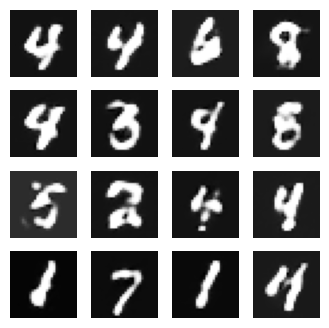

In [ ]:
train(train_dataset_with_cond, EPOCHS)

In [ ]:
anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
embed.embed_file(anim_file)

Zadanie 4.1. Wygeneruj po jednym obrazie z każdą liczbą z pomocą generatora. Oceń jakość wyników. Jeśli jakość modelu pozostawia wiele do życzenia, spróbuj go poprawić, np. zwiększając liczbę epok bądź zmieniając definicję generatora/dyskryminatora.  
Punktacja: 1 pkt za poprawnie przeprowadzony trening i wykonane zadanie 4.1.

In [ ]:
def generate_image_for_every_number(generator, noise_dim, cond_dim):
    fig, axs = plt.subplots(2, 5, figsize = (12, 5))
    axs = axs.ravel()

    for i in range(10):
        noise = tf.random.normal([1, noise_dim])
        label = tf.one_hot([i], depth = cond_dim)
        generated_image = generator([noise, label], training = False)

        axs[i].imshow(generated_image[0, :, :, 0], cmap = 'gray')
        axs[i].set_title(f'Number {i}')
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)

    plt.show()

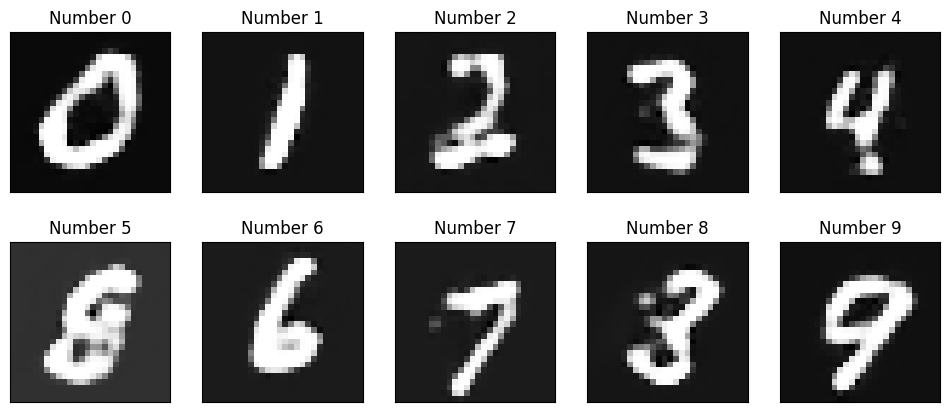

In [ ]:
generate_image_for_every_number(generator, noise_dim, cond_dim)